# Improving Content Based Image Retrieval through Image Segmentation

This demo will take a user given image, segment it and compare the results of the Content Based Image Retrieval system using the original and the segmented image.

## 1. DeepLab Segmentation

This program will use Google's [DeepLab](https://github.com/tensorflow/models/blob/master/research/deeplab/) segmentation algorithm, to segment a given image.

In [1]:
import os
from io import BytesIO
import tarfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import ipywidgets as widgets

import tensorflow as tf

In [2]:
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()
    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map

We use helper functions to create a colormap for the segmented regions of the image and to extract the segments from the original image.

In [74]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expected 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def extract_segment_from_image(image, segment):
  """Extracts a subimage according to the segmented area
    
  Args:
    image: A 2D array of RGB integer values that describe 
      the original (resized) image.
    
    segment: A 2D array of integer values that describe the 
      segmented areas of the image.
    
  Returns:
    return segment_out: A 3D array of RGB integer values that describe
      each of the extracted segments from the original image.
      
  Raises:
    ValueError: If image is not of rank 3 or if segment is not of rank 2
    RunTimeError: If the 2d dimensions of the segment and 
      the original image are not the same
    
  """

  if image.ndim != 3:
    raise ValueError('Expected 2-D RGB image')
  if segment.ndim != 2:
    raise ValueError('Expected 2-D segment')

  if image.shape[:2] != segment.shape:
    raise RunTimeError('Image and segment are not same size')

  unique_segments = np.unique(segment)
  segment_out_shape = (len(unique_segments), ) + image.shape
  segment_out = np.zeros(segment_out_shape, dtype=np.uint8)

  for h in range(len(unique_segments)):
    for i in range(image.shape[0]):
      for j in range(image.shape[1]):
        if segment[i][j] == unique_segments[h]:
          segment_out[h][i][j] = image[i][j]
  return segment_out   

The DeepLab model is trained on the PASCAL VOC2012 dataset. Therefore we manually set the labels that are used in the dataset

In [55]:
LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

We retrieve the pretrained model and prepare our model object

In [56]:
_TARBALL_NAME = 'deeplab_pascal_model.tar.gz'

model_dir = 'segmentation_model/' 
model_name = 'deeplab_model_pascal.tar.gz'

MODEL = DeepLabModel(model_dir + model_name)
print('Model loaded successfully!')

Model loaded successfully!


In [ ]:
def vis_segmentation(image, seg_map, extract):
  """Visualizes input image, segmentation map, overlay view and extracted image."""

  unique_labels = np.unique(seg_map)

  plt.figure(figsize=(20, 20))
  grid_spec = gridspec.GridSpec(2 + len(unique_labels), 4, width_ratios=[6,6,6,6])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('Input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('Segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_map, alpha=0.6)
  plt.axis('off')
  plt.title('Segmentation overlay')

  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')

  for i in range(len(unique_labels)):
    plt.subplot(grid_spec[4 + i])
    plt.imshow(extract[i])
    plt.axis('off')
    plt.title(LABEL_NAMES[unique_labels[i]])

 

  plt.show()

## Run on given or sample image

Enter an image url or choose an example image.

Give an image url or leave blank for a sample image
 https://i.ytimg.com/vi/d8pJkuSp1iI/maxresdefault.jpg


Running deeplab on image: 
 https://i.ytimg.com/vi/d8pJkuSp1iI/maxresdefault.jpg...


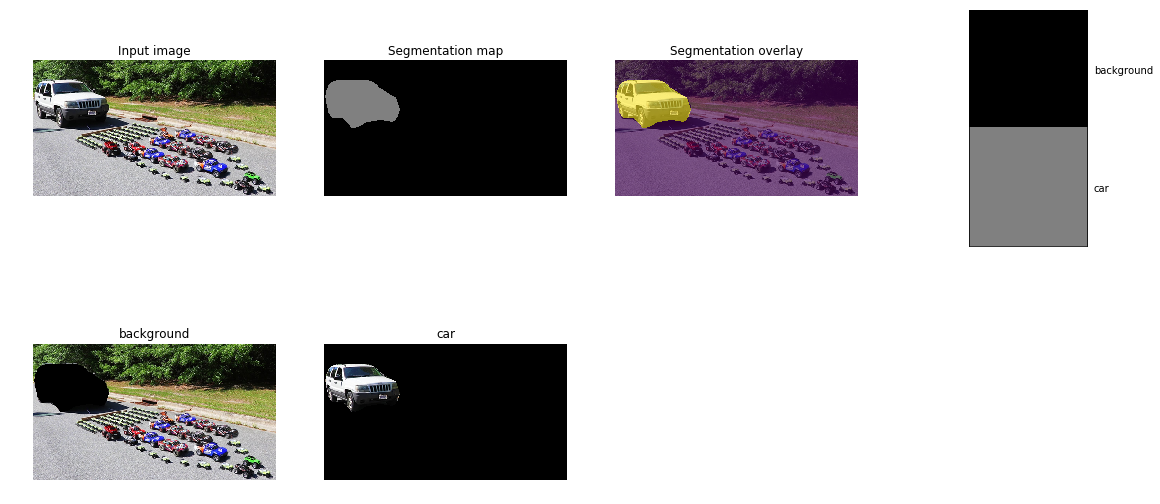

In [138]:
SAMPLE_IMG = 'demo_images/image1.jpg'

def run_segmentation(url):
  """Inferences DeepLab model and visualizes result."""
  if url is SAMPLE_IMG:
    original_im = Image.open(url)
  else:
    try:
      f = urllib.request.urlopen(url)
      jpeg_str = f.read()
      original_im = Image.open(BytesIO(jpeg_str))
    except IOError:
      print('Cannot retrieve image. Please check url: ' + url)
    
  print('Running deeplab on image: \n %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)
  extract = extract_segment_from_image(np.array(resized_im), seg_map)
  vis_segmentation(resized_im, seg_map, extract)
  return resized_im, extract

IMAGE_URL = input('Give an image url or leave blank for a sample image\n')
image_url = IMAGE_URL or SAMPLE_IMG

ORIGINAL, EXTRACT = run_segmentation(image_url)

## 2. Content Based Image Retrieval

Now we run the images through the Content Based Image Retrieval to fetch similar images.